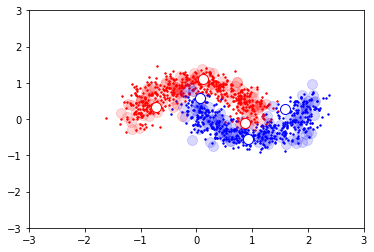

In [1]:
import numpy as np 
from sklearn import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

#dummy data ##########################

num_unlabel = 500
num_train = 3
num_valid = 100

x_unlabel,y_unlabel = datasets.make_moons(n_samples=num_unlabel*2, shuffle=False, noise=0.2, random_state=123)
x_train, y_train = datasets.make_moons(n_samples=num_train*2, shuffle=False, noise=0.2, random_state=456)
x_valid, y_valid = datasets.make_moons(n_samples=num_valid*2, shuffle=False, noise=0.2, random_state=789)
#print(x_unlabel.max(),x_unlabel.min())

grid = torch.meshgrid(torch.linspace(-3, 3, steps=100), torch.linspace(-3, 3, steps=100))#, indexing='ij')
grid = torch.stack(grid,-1)
grid = grid.reshape(-1,2).cuda()



def show_data():
    plt.scatter(x_unlabel[:num_unlabel,0],x_unlabel[:num_unlabel,1], s=2, alpha=1, facecolors='r',)
    plt.scatter(x_unlabel[num_unlabel:,0],x_unlabel[num_unlabel:,1], s=2, alpha=1, facecolors='b',)
    plt.scatter(x_valid[:num_valid,0],x_valid[:num_valid,1], s=100, alpha=0.15, c='r',)
    plt.scatter(x_valid[num_valid:,0],x_valid[num_valid:,1], s=100, alpha=0.15, c='b',)
    plt.scatter(x_train[:num_train,0],x_train[:num_train,1], s=100, alpha=1, edgecolors='r', facecolors='w',)
    plt.scatter(x_train[num_train:,0],x_train[num_train:,1], s=100, alpha=1, edgecolors='b', facecolors='w',)
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])

show_data()
plt.show()



 


In [2]:
# network and display function ##########################


def show_predict_space(net):
    net = net.eval()
    predict = torch.sigmoid(net(grid))
    predict = predict.data.cpu().numpy()
    g = grid.data.cpu().numpy()
    plt.scatter(g[:,0],g[:,1], c=predict)
    show_data()

def print_validate(net):
    
    x = torch.from_numpy(x_valid).float().cuda()
    y = torch.from_numpy(y_valid).float().cuda()
    
    net = net.eval()
    logit = net(x)
    loss = F.binary_cross_entropy_with_logits(logit,y)
    
    predict = (torch.sigmoid(logit)>0.5).long()
    predict = predict.data.cpu().numpy()
    correct = (predict==y_valid).mean()
    
    print('valid BCE loss:', loss.item())
    print('valid accuracy:', correct)
    
    
##########################################################################################

class Residual1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        
        self.linear1 = nn.Linear(dim,dim)
        self.bn1  = nn.BatchNorm1d(dim)
        self.linear2 = nn.Linear(dim,dim)
        self.bn2  = nn.BatchNorm1d(dim)
        self.act = nn.SiLU(inplace=True)
     
    def forward(self, x ):
        residual = x
        x = self.bn1(self.linear1(x))
        x = self.act(x)
        x = self.bn2(self.linear2(x))
        x = residual+x
        x = self.act(x)
        return x
        
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.stem = nn.Sequential(
            nn.Linear(2,128),
            nn.BatchNorm1d(128),
            nn.SiLU(inplace=True),
        )
        self.feature = nn.ModuleList([
            Residual1d(128) for i in range(3)
        ])
        self.logit = nn.Linear(128, 1)
    
     
    def forward(self, x ):
        x = self.stem(x)
        x = self.feature[0](x)
        x = self.feature[1](x)
        x = self.feature[2](x)
        logit = self.logit(x).reshape(-1)
        return logit




upper bound
valid BCE loss: 0.1355268955230713
valid accuracy: 0.945


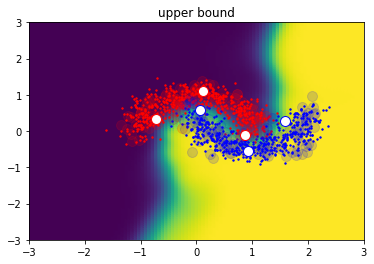

In [3]:
#experiment 1.
if 1:
    #upper bound : train using ground truth of all label+unlabel
    
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    net = Net().cuda()
    optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
    
    for iteration in range(200):
        random_sample = np.random.choice(num_unlabel*2,16).tolist()
        u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
        u_y = torch.from_numpy(y_unlabel[random_sample]).float().cuda()
        
        
        l_logit = net(l_x)
        u_logit = net(u_x)
        loss = (F.binary_cross_entropy_with_logits(l_logit,l_y)+ F.binary_cross_entropy_with_logits(u_logit,u_y))/2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print('\r', iteration, loss.item(), end='', flush=True)
    print('')
    print('upper bound')
    print_validate(net)
    show_predict_space(net)
    plt.title('upper bound')
    plt.show()


labelled only
valid BCE loss: 0.7219110131263733
valid accuracy: 0.645


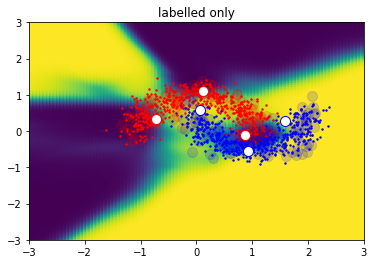

In [4]:
#experiment.2 : using labelled data only
if 1:
    
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    net = Net().cuda()
    optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
    
    for iteration in range(200):
        logit = net(l_x)
        loss = F.binary_cross_entropy_with_logits(logit,l_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #print('\r', iteration, loss.item(), end='', flush=True)
    print('')
    print('labelled only')
    print_validate(net)
    show_predict_space(net)
    plt.title('labelled only')
    plt.show()

metal pseudo label : student
valid BCE loss: 0.5622252821922302
valid accuracy: 0.69


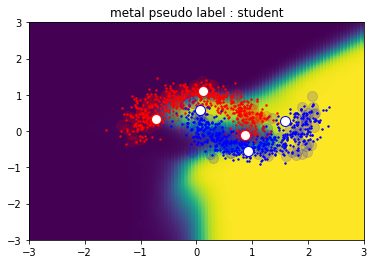

metal pseudo label : teacher
valid BCE loss: 0.44063475728034973
valid accuracy: 0.725


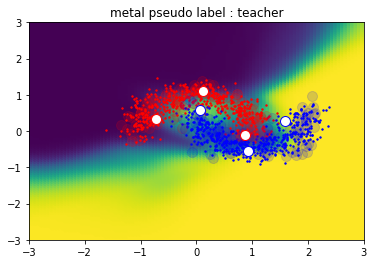

In [5]:
# experiment3: metal pseudo label
# https://github.com/kekmodel/MPL-pytorch/blob/main/main.py
if 1:
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    
    teacher = Net().cuda()
    student = Net().cuda()
    t_optimizer = optim.SGD(teacher.parameters(),lr=0.0005, momentum=0.9)
    s_optimizer = optim.SGD(student.parameters(),lr=0.0005, momentum=0.9)

    for iteration in range(200):
        # subscript: t,s : teacher,student
        # subscript: l,u : label,unlabel
        
        teacher.train()
        student.train()
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()
        
        random_sample = np.random.choice(num_unlabel*2,16).tolist()
        u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
     
        
        #prepare other input
        #note these is detached, i.e. not used for backprop
        s_l_logit = student(l_x)
        s_l_loss = F.binary_cross_entropy_with_logits(s_l_logit.detach(), l_y)
        
        t_u_logit = teacher(u_x)
        pseudo_y =  (t_u_logit.detach()>0).float()
        #------
        
        
        
        #train student : update student using pesudo label data only
        s_u_logit = student(u_x)
        s_u_loss  = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y)
        s_u_loss.backward()
        s_optimizer.step()
        
        
        #train teacher : update teacher using pesudo label data student change in loss
        s_l_logit_new = student(l_x)
        s_l_loss_new  = F.binary_cross_entropy_with_logits(s_l_logit_new.detach(), l_y)
        #change = s_l_loss - s_l_loss_new #s_l_loss_new - s_l_loss ??
        change = s_l_loss_new - s_l_loss
        #https://github.com/kekmodel/MPL-pytorch/issues/6
        
        t_l_logit = teacher(l_x)
        t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, l_y)
        t_mpl_loss  = change * F.binary_cross_entropy_with_logits(t_u_logit, pseudo_y)
        
        (t_l_loss+t_mpl_loss).backward()
        t_optimizer.step()
    
        #print(iteration, s_u_loss.item(), t_l_loss.item(), t_mpl_loss.item())
    #-------------------------------
    print('metal pseudo label : student')
    print_validate(student)
    show_predict_space(student)
    plt.title('metal pseudo label : student')
    plt.show()
    
    print('metal pseudo label : teacher')
    print_validate(teacher)
    show_predict_space(teacher)
    plt.title('metal pseudo label : teacher')
    plt.show()


metal pseudo label (exact) : student
valid BCE loss: 0.3092239797115326
valid accuracy: 0.785


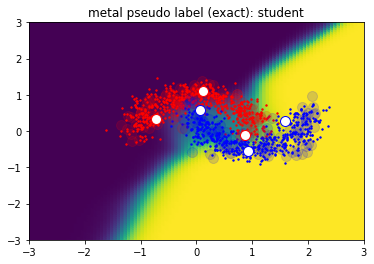

metal pseudo label (exact): teacher
valid BCE loss: 0.39673912525177
valid accuracy: 0.785


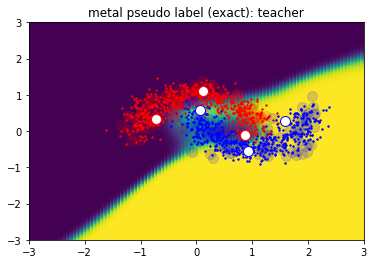

In [6]:
# experiment4: meta-pesudo-label ( exact, no approximation)
# https://zhuanlan.zhihu.com/p/396127336

if 1:
    l_x = torch.from_numpy(x_train).float().cuda()
    l_y = torch.from_numpy(y_train).float().cuda()
    
    
    teacher = Net().cuda()
    student = Net().cuda()
    t_optimizer = optim.SGD(teacher.parameters(),lr=0.001, momentum=0.9)
    s_optimizer = optim.SGD(student.parameters(),lr=0.001, momentum=0.9)
    
    for iteration in range(200):
        # subscript: t,s : teacher,student
        # subscript: l,u : label,unlabel
        
        teacher.train()
        student.train()
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()
        
        random_sample = np.random.choice(num_unlabel*2,16).tolist()
        u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
        
        
        #prepare other input
        #note these is detached, i.e. not used for backprop
        #s_l_logit = student(l_x)
        #s_l_loss = F.binary_cross_entropy_with_logits(s_l_logit.detach(), l_y)
        
        t_u_logit = teacher(u_x)
        pseudo_y =  torch.sigmoid(t_u_logit) #t_u_logit>0).float()
        #------
        
        
        
        #train student : update student using pesudo label data only
        s_u_logit = student(u_x)
        s_u_loss  = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y,reduction='none')
        s_u_loss  = s_u_loss[torch.abs(pseudo_y-0.5)>0.45].mean()
        s_u_loss.backward()
        s_optimizer.step()
        
        
        #train teacher : update teacher using pesudo label data student change in loss
        s_l_logit_new = student(l_x)
        s_l_loss_new  = F.binary_cross_entropy_with_logits(s_l_logit_new, l_y)
        t_mpl_loss    = s_l_loss_new
        
        t_l_logit = teacher(l_x)
        t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, l_y)
        
        
        (t_l_loss+t_mpl_loss).backward()
        #(t_mpl_loss).backward()
        t_optimizer.step()
        
       
        #print(iteration, s_u_loss.item(), t_l_loss.item(), t_mpl_loss.item())
    #-------------------------------
    print('metal pseudo label (exact) : student')
    print_validate(student)
    show_predict_space(student)
    plt.title('metal pseudo label (exact): student')
    plt.show()
    
    print('metal pseudo label (exact): teacher')
    print_validate(teacher)
    show_predict_space(teacher)
    plt.title('metal pseudo label (exact): teacher')
    plt.show()
